# Evaluation of our Neural Network Models (on TfIdf vectorized dataset).

## Import useful libraries.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import string
import re
import nltk
import pickle

from gensim.utils import simple_preprocess
from gensim import corpora

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression 
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.metrics import recall_score,f1_score,precision_score,classification_report,roc_curve, auc
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import label_binarize

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from google.colab import drive
drive.mount('/content/drive/')
nltk.download('wordnet')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Retrieve and clean our dataset.

### Retrieve and display our dataset!

In [2]:
data = pd.read_csv(r'/content/drive/My Drive/AI(II)/datasets/SentimentTweets.csv',nrows=500000)

X = pd.DataFrame(data['text'],columns=['text'])
Y = pd.DataFrame(data['target'],columns=['target'])

display(X,Y)

,text
0,#brokenpromises...
1,David Carradine so sad. Thai's law not sure i...
2,A @ 415 B @ 425. Tell your bro i say congrats!
3,@littlefluffycat Indeed.
4,Completed Race 4 Life in 58mins with girlies f...
...,...
499995,@SkyNews they've finally managed to kill F1!
499996,@elvensapphire I'm brazilian so brazilian are ...
499997,@ScherziNicole Aww thats so sweet! I joined a ...
499998,Woke up kinda depressed and sad


,target
0,0
1,0
2,4
3,4
4,4
...,...
499995,0
499996,0
499997,4
499998,0


### Convert to lowercase.

In [3]:
X['text'] = X['text'].str.lower()
display(X)

,text
0,#brokenpromises...
1,david carradine so sad. thai's law not sure i...
2,a @ 415 b @ 425. tell your bro i say congrats!
3,@littlefluffycat indeed.
4,completed race 4 life in 58mins with girlies f...
...,...
499995,@skynews they've finally managed to kill f1!
499996,@elvensapphire i'm brazilian so brazilian are ...
499997,@scherzinicole aww thats so sweet! i joined a ...
499998,woke up kinda depressed and sad


### Replace where is 4 to 1 (binary form).

In [4]:
Y = Y.replace(4,1)
display(Y)
print(Y.value_counts())

,target
0,0
1,0
2,1
3,1
4,1
...,...
499995,0
499996,0
499997,1
499998,0


target
1         250800
0         249200
dtype: int64


> As we can see classes (negative-positive) are uniformly distributed.

### Removal of special characters and punctuation.

In [5]:
def remove_special_characters(text, remove_digits=True):
  pattern = r'[^a-zA-z0-9\s]'
  text = re.sub(pattern,'',text)
  return text

X['text'] = X['text'].apply(lambda x:''.join([i for i in x if i not in string.punctuation]))

X['text'] = X['text'].apply(remove_special_characters)

display(X)

,text
0,brokenpromises
1,david carradine so sad thais law not sure if ...
2,a 415 b 425 tell your bro i say congrats
3,littlefluffycat indeed
4,completed race 4 life in 58mins with girlies f...
...,...
499995,skynews theyve finally managed to kill f1
499996,elvensapphire im brazilian so brazilian are an...
499997,scherzinicole aww thats so sweet i joined a wh...
499998,woke up kinda depressed and sad


### Tokenization.

In [6]:
X['text'] = [simple_preprocess(line, deacc=True) for line in X['text']] 

display(X)

,text
0,[brokenpromises]
1,"[david, carradine, so, sad, thais, law, not, s..."
2,"[tell, your, bro, say, congrats]"
3,"[littlefluffycat, indeed]"
4,"[completed, race, life, in, mins, with, girlie..."
...,...
499995,"[skynews, theyve, finally, managed, to, kill]"
499996,"[elvensapphire, im, brazilian, so, brazilian, ..."
499997,"[scherzinicole, aww, thats, so, sweet, joined,..."
499998,"[woke, up, kinda, depressed, and, sad]"


### Lemmatization.

In [7]:
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
    return " ".join([lemmatizer.lemmatize(w, pos="v") for w in text])

X['text'] = X['text'].apply(lemmatize_text)

display(X)

,text
0,brokenpromises
1,david carradine so sad thais law not sure if i...
2,tell your bro say congrats
3,littlefluffycat indeed
4,complete race life in mins with girlies from w...
...,...
499995,skynews theyve finally manage to kill
499996,elvensapphire im brazilian so brazilian be any...
499997,scherzinicole aww thats so sweet join while ag...
499998,wake up kinda depress and sad


### Split dataset to train,validation and test dataset.


In [8]:
# Split dataset to train and test set.
X_train, X_test, Y_train, Y_test = train_test_split(X['text'],Y['target'],test_size=0.005)

# Split train dataset to train and validation set.
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.005)

print("X_train's shape:", X_train.shape)
print("Y_train's shape:", Y_train.shape)
print("X_val's shape:", X_val.shape)
print("Y_val's shape:", Y_val.shape)
print("X_test's shape:", X_test.shape)
print("Y_test's shape:", Y_test.shape)

X_train's shape: (495012,)
Y_train's shape: (495012,)
X_val's shape: (2488,)
Y_val's shape: (2488,)
X_test's shape: (2500,)
Y_test's shape: (2500,)


>We choosed to split dataset 99%-1% (train and test set), cause our dataset is too large. 


## Vectorization.

### TfIdf Vectorization.

In [9]:
# Vectorize our train corpus with TfIdf Vectorizer.
tfidf = TfidfVectorizer(max_features=1000,dtype=np.float32)

# For train data apply fit_transform.
tfidf_X_train = tfidf.fit_transform(X_train)
tfidf_X_train = tfidf_X_train.toarray()

# For validation data apply transform.
tfidf_X_val = tfidf.transform(X_val)
tfidf_X_val = tfidf_X_val.toarray()

# For test data apply transform.
tfidf_X_test = tfidf.transform(X_test)
tfidf_X_test = tfidf_X_test.toarray()

print("tfidf_X_train's shape:", tfidf_X_train.shape)
print("tfidf_X_val's shape:", tfidf_X_val.shape)
print("tfidf_X_test's shape:", tfidf_X_test.shape)

tfidf_X_train's shape: (495012, 1000)
tfidf_X_val's shape: (2488, 1000)
tfidf_X_test's shape: (2500, 1000)


#### Convert tfidf_X datasets to tensors with help of library PyTorch.







In [10]:
# Convert X datasets to tensors with function convert_to_tensor.
tfidf_X_train = torch.tensor(tfidf_X_train)
tfidf_X_val = torch.tensor(tfidf_X_val)
tfidf_X_test = torch.tensor(tfidf_X_test)

print("X_train's shape:", tfidf_X_train.shape)
print("X_val's shape:", tfidf_X_val.shape)
print("X_test's shape:", tfidf_X_test.shape)

X_train's shape: torch.Size([495012, 1000])
X_val's shape: torch.Size([2488, 1000])
X_test's shape: torch.Size([2500, 1000])



### Convert Y datasets (labels) to tensors with help of library PyTorch.

In [11]:
# Convert Y labels to tensors with torch.squeeze.
Y_train = torch.squeeze(torch.from_numpy(Y_train.to_numpy()).float())
Y_val = torch.squeeze(torch.from_numpy(Y_val.to_numpy()).float())
Y_test = torch.squeeze(torch.from_numpy(Y_test.to_numpy()).float())

print("Y_train's shape:", Y_train.shape)
print("Y_val's shape:", Y_val.shape)
print("Y_test's shape:", Y_test.shape)

Y_train's shape: torch.Size([495012])
Y_val's shape: torch.Size([2488])
Y_test's shape: torch.Size([2500])


## Prepare GPU Cuda.

### Initial step with PyTorch, check if gpu cuda is available.

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device available for running: ")
print(device)

Device available for running: 
cuda


### Transfer all the computation to GPU (cuda device).


In [13]:
tfidf_X_train = tfidf_X_train.to(device)
tfidf_X_val = tfidf_X_val.to(device)
tfidf_X_test = tfidf_X_test.to(device)

Y_train = Y_train.to(device)
Y_val = Y_val.to(device)
Y_test = Y_test.to(device)

## Implementation of function, which is gonna train our models.

In [14]:
def calculate_accuracy(y_true, y_pred):  
  y_pred = torch.round(y_pred)
  correct = (y_true == y_pred).float() 
  acc = correct.sum() / len(correct)
  return acc

def train_model(model,criterion,optimizer,x_train,x_val,y_train,y_val,epochs=100,batch_size=10000):

  # Declare empty lists.
  train_losses = []
  train_accs = []
  val_losses = []
  val_accs = []

  # Split train dataset to mini batches
  X_train_mini_batches = torch.split(x_train,batch_size)
  Y_train_mini_batches = torch.split(y_train,batch_size)

  # Start training
  for epoch in range(epochs):

    # Clear previous values of variables.
    epoch_loss = 0
    epoch_acc = 0
    validation_loss=0
    val_acc=0

    for X_train_mini_batch,Y_train_mini_batch in zip(X_train_mini_batches,Y_train_mini_batches):
      
      # Forward pass to get output.
      train_pred = model.fit(X_train_mini_batch.float())
      train_pred = torch.squeeze(train_pred)

      # Calculate Loss.
      train_loss = criterion(train_pred,Y_train_mini_batch)

      # Clearing up accumulated gradients.
      optimizer.zero_grad()
      
      # Getting gradients w.r.t. parameters.
      train_loss.backward()

      # Updating parameters.
      optimizer.step()

      # Add each mini batch's loss.
      epoch_loss += train_loss.item()

      # Add each mini batch's accuracy.
      epoch_acc += calculate_accuracy(Y_train_mini_batch,train_pred)

      
    # For each epoch test our model on validation set.
    val_pred = model.fit(x_val.float())
    val_pred = torch.squeeze(val_pred)
      
    # Calculate Loss
    val_loss = criterion(val_pred,y_val) 

    # Calculate val's loss
    validation_loss = val_loss.item()

    # Calculate val's accuracy
    val_acc = calculate_accuracy(y_val,val_pred)

    # Calculate mean loss and mean accuracy for train data.
    epoch_loss /= len(X_train_mini_batches)
    epoch_acc /= len(X_train_mini_batches)
    
    # Add them to appropriate lists so as to return them.
    val_losses.append(validation_loss)
    val_accs.append(val_acc)
    train_losses.append(epoch_loss)
    train_accs.append(epoch_acc)

  return train_losses,val_losses,train_accs,val_accs

## First Neural Network Model.

### Implementation of class FirstModel, which is our first Neural Network.

In [15]:
class FirstModel(nn.Module):
    
  def __init__(self, input_dim, hidden_dim1,hidden_dim2):
    super(FirstModel, self).__init__()
    
    self.relu = nn.ReLU()
    self.layer1 = nn.Linear(input_dim, hidden_dim1) 
    self.layer2 = nn.Linear(hidden_dim1, hidden_dim2)
    self.layer3 = nn.Linear(hidden_dim2, 1)  
    
  def fit(self, x):
    
    # Layer 1
    out = self.relu(self.layer1(x))
 
    # Layer 2
    out = self.relu(self.layer2(out))

    # Layer 3    
    out = torch.sigmoid(self.layer3(out))

    return out 

  def evaluate(self,x_test,y_test,report=False):
  
    # Forward pass to get predictions.
    test_pred = self.fit(x_test.float())
    test_pred = torch.squeeze(test_pred)
    
    # Score by manually implemented calculate accuracy
    test_acc = round(calculate_accuracy(y_test,test_pred).item(),2)

    # Classification report
    if report==True:
      test_pred = test_pred.ge(.5).view(-1).cpu()
      y_test = y_test.cpu()
      print(classification_report(y_test,test_pred))

    return test_acc

### Prepare our first non deep feed forward neural network model.

In [33]:
input_units = tfidf_X_train.shape[1]
hidden_units1 = 128
hidden_units2 = 128
learning_rate = 1e-4
w_decay = 1e-4

# Define our first feed forward neural network with different input datasets (tfidf and glove vectorized).
tfidf_first_model = FirstModel(input_units,hidden_units1,hidden_units2)

# Define loss function.
criterion = nn.BCELoss()

# Define as optimizer Adam.
optimizer = optim.Adam(tfidf_first_model.parameters(),lr=learning_rate,weight_decay=w_decay)

# Transfer all the computation to GPU (cuda device).
tfidf_first_model.to(device)
criterion = criterion.to(device)

### Train our first model with TfIdf vectorized input.

In [34]:
# Call train_model with appropriate args and store into lists losses and accuracies.
tfidf_train_losses,tfidf_val_losses,tfidf_train_accs,tfidf_val_accs = train_model(tfidf_first_model,criterion,optimizer,tfidf_X_train,tfidf_X_val,Y_train,Y_val,epochs=100,batch_size=10000)

### Let's check what happened in training on first TfIdf model.


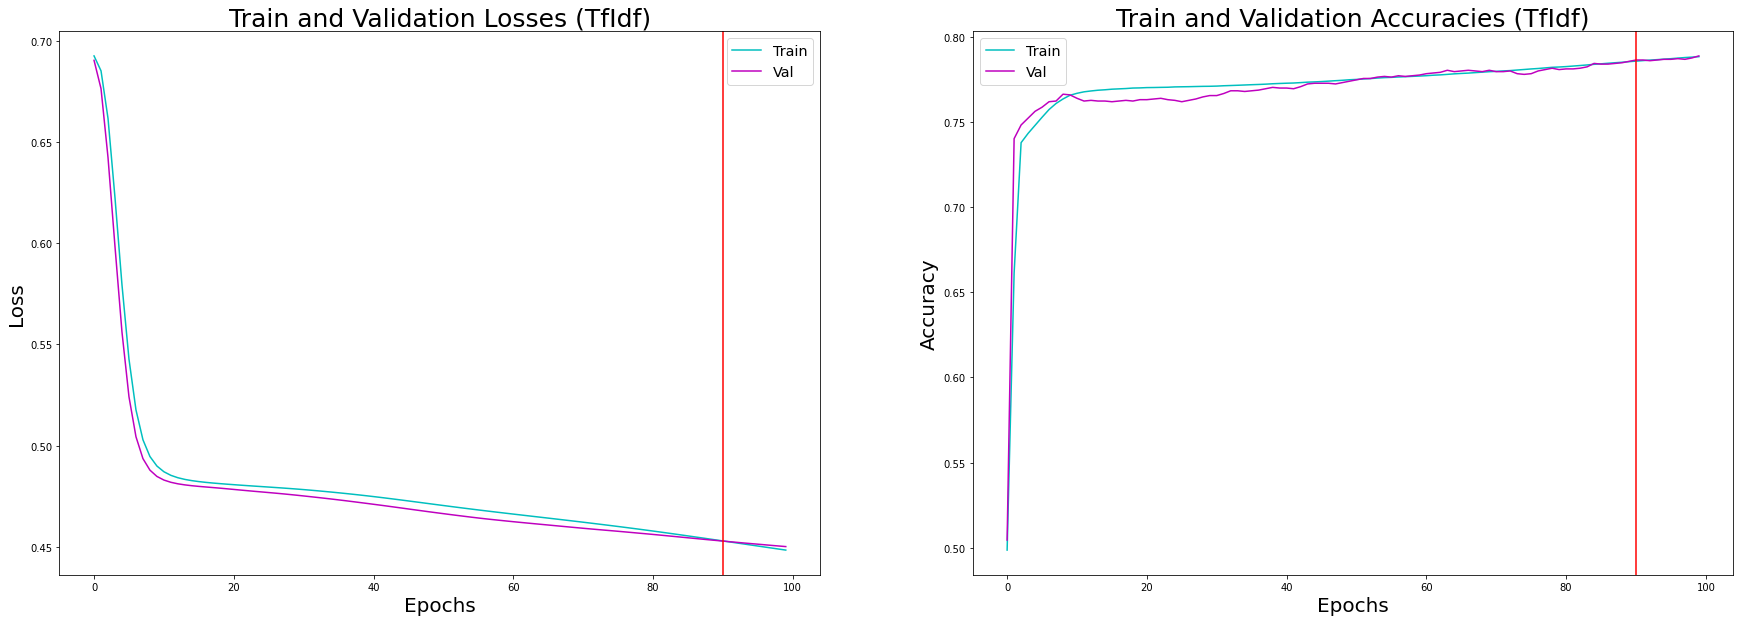

In [38]:
fig,axs = plt.subplots(1,2,figsize=(30,10))

early_stopping = 90

# Plot Train and Validation Losses with TfIdf vectorization.
axs[0].set_title("Train and Validation Losses (TfIdf)",size=25)
axs[0].set_ylabel('Loss', fontsize = 20.0) 
axs[0].set_xlabel('Epochs', fontsize = 20) 
_=axs[0].plot(tfidf_train_losses,'-c')
_=axs[0].plot(tfidf_val_losses,'-m')
_=axs[0].axvline(x=early_stopping,color='r')
_=axs[0].legend(('Train','Val'),loc='upper right',fontsize='x-large')

# Plot Train and Validation Accuracies with TfIdf vectorization.
axs[1].set_title("Train and Validation Accuracies (TfIdf)",size=25)
axs[1].set_ylabel('Accuracy', fontsize = 20.0) 
axs[1].set_xlabel('Epochs', fontsize = 20) 
_=axs[1].plot(tfidf_train_accs,'-c')
_=axs[1].plot(tfidf_val_accs,'-m')
_=axs[1].axvline(x=early_stopping,color='r')
_=axs[1].legend(('Train','Val'),loc='best',fontsize='x-large')

### Evaluation of our first TfIdf model with classification report and with manually implemented calculate_accuracy() function.

In [52]:
print("First TfIdf Model Test's Accuracy:",tfidf_first_model.evaluate(tfidf_X_test,Y_test,True))

              precision    recall  f1-score   support

         0.0       0.77      0.79      0.78      1228
         1.0       0.79      0.77      0.78      1272

    accuracy                           0.78      2500
   macro avg       0.78      0.78      0.78      2500
weighted avg       0.78      0.78      0.78      2500

First TfIdf Model Test's Accuracy: 0.78


### General Notes about our first TfIdf NN model.

> Our Neural Network Model has the above structure:

> input dimensions (Relu) -> 128 (Relu) -> 128 (Sigmoid) -> 1

> For input of NN we vectorized our tweets with help of TfIdf Vectorizer from sklearn, but we had to keep only 1000 features with biggest values of TfIdf, due to memory limit. In that way we could load only the first half million rows of our dataset.

### Experiment's Conclusions.

> After many experiments with our model we observe that in order to avoid overfitting we had to choose a simplier model architecture, so we tried non deep NN model with 2 hidden layers. 

> After studying and reading in articles and books with topic 'Machine Learning' and 'Deep Learning', out there everybody for binary classification problems recommends as criterion Binary Cross Entropy Loss and as optimizer with descent performance Adam. I can confirm these thoughts cause other criterions and optimizers didn't perform well.

> After that we randomly found the appropriate learning rate, which is the most significant parameter, so as to have a good fit. 

> The weight decay parameter adds a L2 penalty to the cost which can effectively lead to to smaller model weights. This helped us a lot with tackling overfitting.

> We set batch size to default 10.000, cause we have a huge dataset so as to run our model much faster.

> We experimented a lot with number of hidden units and finally ended up to 128 and 128 respectively. We prefer hidden units to be 2^k in order to help memory management of our computer.




### Plot ROC-Curve for our best model!

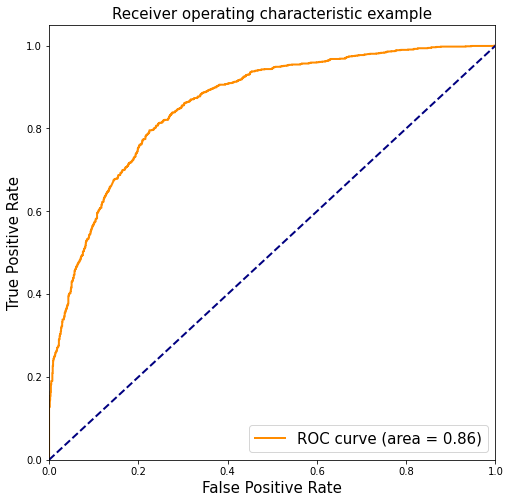

In [37]:
# Get predictions of our best NN model.
y_score = tfidf_first_model.fit(tfidf_X_test.float())

# Convert tensors to numpy arrays.
y_score = y_score.cpu().detach().numpy()
y = Y_test.cpu().detach().numpy()

# Label binarization and store num of classes.
y_test = label_binarize(y, classes=[0, 1])
n_classes = y_test.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:,i], y_score[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8,8))
lw = 2
plt.plot(fpr[0], tpr[0], color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[0])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate',fontsize=15)
plt.ylabel('True Positive Rate',fontsize=15)
plt.title('Receiver operating characteristic example',fontsize=15)
plt.legend(loc="lower right",fontsize=15)
plt.show()

### Extra Results.

> Until now out first non deep (TfIdf Vectorized) Neural Network Model is the best with 0.78 score compared to our non deep (GloVe Vectorized) Neural Network Model which has 0.70 score! This difference was expected, due to the fact that TfIdf model keeps much more information compared to GloVe model (to be more specific each tweet has dimensions 1000 and 50 respectively). However both of them were pretty descent as models since they had a good fit (observed from learning curves).

> From the theory we taught that a deep Neural Network Model (with a lot of hidden layers and hidden units) is more possible to give us greater scores. So let's give it a last shot and see if we have a new winner!

## Second Neural Network Model.

### Implementation of class SecondModel, which is our second Neural Network.

In [39]:
class SecondModel(nn.Module):
    
  def __init__(self,input_dim,hidden_dim1):
    super(SecondModel, self).__init__()
    
    self.relu = nn.ReLU()

    self.layer1 = nn.Linear(input_dim,hidden_dim1) 
    self.layer2 = nn.Linear(hidden_dim1,hidden_dim1)
    self.layer3 = nn.Linear(hidden_dim1,hidden_dim1)
    self.layer4 = nn.Linear(hidden_dim1,hidden_dim1)
    self.layer5 = nn.Linear(hidden_dim1,hidden_dim1)
    self.layer6 = nn.Linear(hidden_dim1,1)

  def fit(self, x):

    # Layer 1
    out = self.relu(self.layer1(x))
    # Layer 2
    out = self.relu(self.layer2(out))
    # Layer 3
    out = self.relu(self.layer3(out))
    # Layer 4
    out = self.relu(self.layer4(out))
    # Layer 5
    out = self.relu(self.layer5(out))
    # Layer 6
    out = torch.sigmoid(self.layer6(out))
    
    return out 

  def evaluate(self,X_test,Y_test,report=False):
  
    # Forward pass to get predictions.
    test_pred = self.fit(X_test.float())
    test_pred = torch.squeeze(test_pred)
    
    # Score by manually implemented calculate accuracy
    test_acc = round(calculate_accuracy(Y_test,test_pred).item(),2)

    # Classification report
    if report==True:
      test_pred = test_pred.ge(.5).view(-1).cpu()
      Y_test = Y_test.cpu()
      print(classification_report(Y_test,test_pred))

    return test_acc

### Prepare our second deep feed forward neural network model.

In [45]:
input_units = tfidf_X_train.shape[1]
hidden_units = 128
learning_rate = 1e-4
w_decay = 1e-4

# Define our second feed forward neural network (tfidf vectorized).
tfidf_second_model = SecondModel(input_units,hidden_units)

# Define loss function.
criterion = nn.BCELoss()

# Define as optimizer Adam.
optimizer = optim.Adam(tfidf_second_model.parameters(),lr=learning_rate,weight_decay=w_decay)

# Transfer all the computation to GPU (cuda device).
tfidf_second_model.to(device)
criterion = criterion.to(device)

### Train our second model with TfIdf vectorized input.

In [46]:
# Call train_model with appropriate args and store into lists losses and accuracies.
tfidf_train_losses,tfidf_val_losses,tfidf_train_accs,tfidf_val_accs = train_model(tfidf_second_model,criterion,optimizer,tfidf_X_train,tfidf_X_val,Y_train,Y_val,epochs=30,batch_size=10000)

### Let's check what happened in training on second TfIdf model.


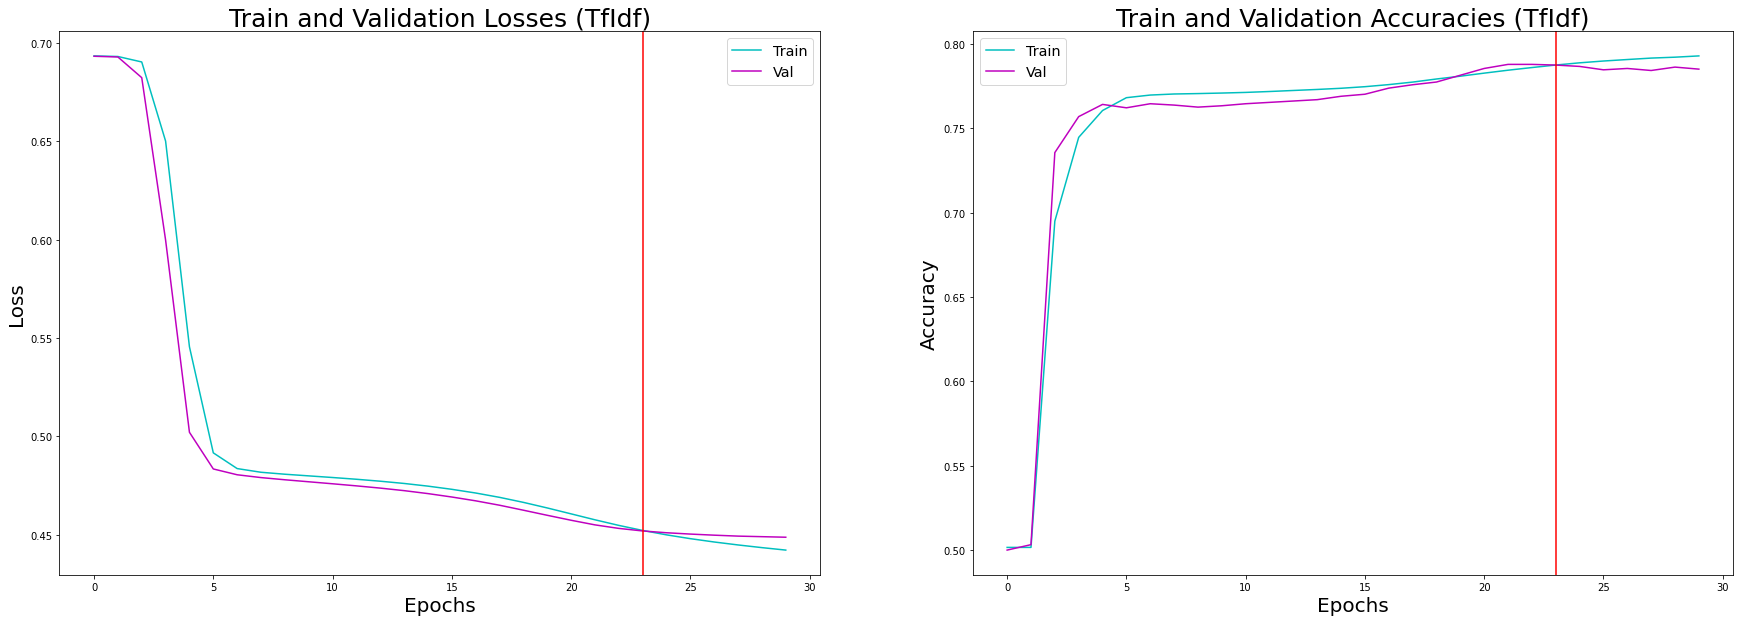

In [50]:
fig,axs = plt.subplots(1,2,figsize=(30,10))

early_stopping = 23

# Plot Train and Validation Losses with TfIdf vectorization.
axs[0].set_title("Train and Validation Losses (TfIdf)",size=25)
axs[0].set_ylabel('Loss', fontsize = 20.0) 
axs[0].set_xlabel('Epochs', fontsize = 20) 
_=axs[0].plot(tfidf_train_losses,'-c')
_=axs[0].plot(tfidf_val_losses,'-m')
_=axs[0].axvline(x=early_stopping,color='r')
_=axs[0].legend(('Train','Val'),loc='upper right',fontsize='x-large')

# Plot Train and Validation Accuracies with TfIdf vectorization.
axs[1].set_title("Train and Validation Accuracies (TfIdf)",size=25)
axs[1].set_ylabel('Accuracy', fontsize = 20.0) 
axs[1].set_xlabel('Epochs', fontsize = 20) 
_=axs[1].plot(tfidf_train_accs,'-c')
_=axs[1].plot(tfidf_val_accs,'-m')
_=axs[1].axvline(x=early_stopping,color='r')
_=axs[1].legend(('Train','Val'),loc='best',fontsize='x-large')

### Evaluation of our second model with classification report and with manually implemented calculate_accuracy() function.

In [48]:
print("Second TfIdf Model Test's Accuracy:",tfidf_second_model.evaluate(tfidf_X_test,Y_test,True))

              precision    recall  f1-score   support

         0.0       0.78      0.78      0.78      1228
         1.0       0.79      0.78      0.78      1272

    accuracy                           0.78      2500
   macro avg       0.78      0.78      0.78      2500
weighted avg       0.78      0.78      0.78      2500

Second TfIdf Model Test's Accuracy: 0.78


### General Notes about our second TfIdf NN model.

> Our Neural Network Model has the above structure:

> Input Layer (Relu) -> 5 hidden Layers with units=128 (Relu) -> Output Layer units=1 (Sigmoid)

> For input of NN we vectorized our tweets with help of TfIdf Vectorizer from sklearn, but we had to keep only 1000 features with biggest values of TfIdf, due to memory limit. In that way we could load only the first half million rows of our dataset.

### Experiment's Conclusions.

> After many experiments with our deep NN model we observe that our model has a big complexity due to its depth. So this affects overfitting, which we can see that takes place after approximately epoch 23. 

> After studying and reading in articles and books with topic 'Machine Learning' and 'Deep Learning', out there everybody for binary classification problems recommends as criterion Binary Cross Entropy Loss and as optimizer with descent performance Adam. I can confirm these thoughts cause other criterions and optimizers didn't perform well.

> The weight decay parameter adds a L2 penalty to the cost which can effectively lead to to smaller model weights. This helped us a lot with tackling overfitting.

> We set batch size to default 10.000, cause we have a huge dataset so as to run our model much faster.

> We experimented a lot with number of hidden units and finally ended up to agic number 128. We prefer hidden units to be 2^k in order to help memory management of our computer.




### Plot ROC-Curve for our best model!

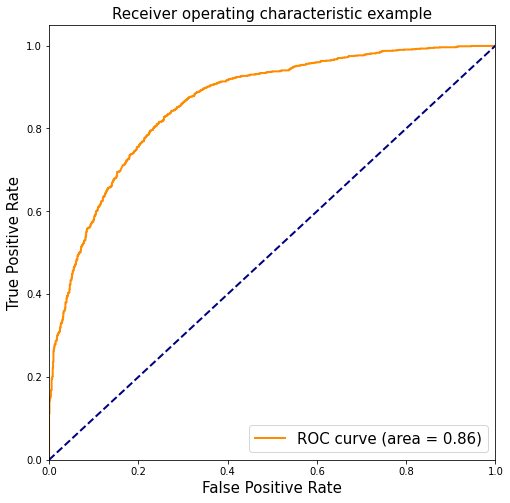

In [51]:
# Get predictions of our best NN model.
y_score = tfidf_second_model.fit(tfidf_X_test.float())

# Convert tensors to numpy arrays.
y_score = y_score.cpu().detach().numpy()
y = Y_test.cpu().detach().numpy()

# Label binarization and store num of classes.
y_test = label_binarize(y, classes=[0, 1])
n_classes = y_test.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:,i], y_score[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8,8))
lw = 2
plt.plot(fpr[0], tpr[0], color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[0])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate',fontsize=15)
plt.ylabel('True Positive Rate',fontsize=15)
plt.title('Receiver operating characteristic example',fontsize=15)
plt.legend(loc="lower right",fontsize=15)
plt.show()

### Final Results.

> After this quick look in deep tfidf NN model we understood that our current dataset is pretty much susceptible to overfitting (if we apply it to a complex model with many hidden layers and many hidden units much more susceptible). 

> Despite the fact that our 2 Tfidf models have exaclty the same score, 0.78, we cannot ignore the fact that in our deep model overfitting was a big problem and we couldln't decrease it due to second's model's complexity, so we apply technique of early stopping.

> From the other hand, deep NN model reached 0.78 only with training of 30 epochs, compared to swallow first tfidf model which needed almost 100 epochs. And here is the big difference... The deepest NN model needed less epochs cause has 5 hidden layers so can more easily learn than the swallow one... So the theory,that we mentioned before, came true!

> So... I believe that we have 2 winners! Between our 3 models (GloVe and 2 TfIdf models) our winners are our 2 Tfidf models with score 0.78.

1. The swallow (first) TfIdf model overcomes problem of overfitting with early 
stopping in epoch 90, with only 2 hidden layers (plus advantage is its very descent and smooth learning curves).

2. The deep (second) TfIdf model overcomes problem of overfitting with early 
stopping in epoch 23, with 5 hidden layers. 

> For that reason we plot ROC Curve for both TfIdf models...

> Compared with previous assigment Logistic Regression Model input dataset be our 500.000 first tweets and crucial parameter (max_features=1000) had score 0.77. So our TfIdf NN models performed better with neglible difference, 0.01.

> Final Note: Compared to GloVe model it was pretty much obvious that GloVe will perform worse, due to limited information (50 dimensions for each word and for each tweet with our technique). Note that we try and other pre trained GloVe models with much more dimensions, for example 200,400 dimensions, but there overfitting was inevitable.